In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ML team project/Project 2/Neubauer Chamber Automation

!pip install import-ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/12swurGjFVTSgi6fpziRcJ-tqsj6OoBgK/ML team project/Project 2/Neubauer Chamber Automation


In [ ]:
import import_ipynb
from DataSets import NeubauerDataset
from UNetModel import UNet

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize, RandomCrop

import numpy as np
import cv2
import time
import os

import matplotlib.pyplot as plt


## Loss Functions

Taken from: https://github.com/marshuang80/cell-segmentation

In [ ]:
def dice_loss(pred, target):
    """Cacluate dice loss 
    Parameters
    ----------
        pred:
            predictions from the model
        target:
            ground truth label
    """
                                                                         
    smooth = 1e-6                                                          
                                                                         
    p_flat = pred.contiguous().view(-1)                                   
    t_flat = target.contiguous().view(-1)                                 
    intersection = (p_flat * t_flat).sum()                                 
                                                                         
    a_sum = torch.sum(p_flat * p_flat)                                     
    b_sum = torch.sum(t_flat * t_flat)                                     
                                                                         
    return 1 - ((2. * intersection + smooth) / (a_sum + b_sum + smooth) )

def combined_loss(pred, target):
    return nn.CrossEntropyLoss(pred, target) + dice_loss(pred, target)

Different DiceLoss from https://kornia.readthedocs.io/en/v0.1.2/_modules/torchgeometry/losses/dice.html


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.eps: float = 1e-6

    def forward(self, input, target):
        # compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1)

        # create the labels one hot tensor
        target_one_hot = target#F.one_hot(target, num_classes=input.shape[1])

        # compute the actual dice score
        dims = (1, 2, 3)
        intersection = torch.sum(input_soft * target_one_hot, dims)
        cardinality = torch.sum(input_soft + target_one_hot, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)
        return torch.mean(1. - dice_score)

class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.DL = DiceLoss()
        self.CEL = nn.CrossEntropyLoss()
    def forward(self, input, target):
        return self.DL(input, target) + self.CEL(input, target)

# Training

## Training functions

In [ ]:
import pickle
def train(model, optimiser, criterion, dataset):
    model.train()
    train_loss = 0
    #Iterate over data
    for i, data in enumerate(dataset):
        if i%50==0:
            print('Iteration %d'%i)
        image, mask = data
        image, mask = image.to(device), mask.to(device)
        optimiser.zero_grad()
        #Get predictions
        output = model(image)
        #Compare predicitons to ground truth
        loss = criterion(output, mask)
        loss.backward()
        optimiser.step()

        #Update running loss
        train_loss += loss.data.item()
    return train_loss

def validate(model, dataset, criterion):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for data in dataset:
            image, mask = data
            image, mask = image.to(device), mask.to(device)
            optimiser.zero_grad()
            #Get predictions
            output = model(image)
            #Compare predicitons to ground truth
            loss = criterion(output, mask)

            #Update running loss
            eval_loss += loss.data.item()
    #Return accuracy
    return eval_loss/len(dataset) 

def run_model(model, dataloaders, optimiser, criterion, model_name, epochs):
    #Split the dataloader. Here we are also evaluating the train set as the ground truth
    train_loader = dataloaders['train']
    val_loader = dataloaders['validation']
    test_loader = dataloaders['test']
    #test_loader = dataset['test']
    train_losses = []
    val_losses = []
    #Train and evaluate
    for epoch in range(1, epochs+1):
        #Reduce learning rate
        if epoch in [25, 40]:
            for param_group in optimiser.param_groups:
                param_group['lr'] /= 10

        #Print and log training loss
        print('----------Epoch %d----------'%epoch)
        train_loss = train(model, optimiser, criterion, train_loader)
        print('Train loss: ', train_loss/len(train_loader))
        train_losses.append(train_loss/len(train_loader))
        
        #Evaluate the model
        if epoch%5 == 0:
            #Evaluate accuracy with the Validation set
            val_accuracy = validate(model, val_loader, criterion)
            print('Validation Accuracy: ', val_accuracy)
            val_losses.append(val_accuracy)
    
    #Save the losses
    pickle.dump([train_losses,val_losses],open(model_name+'.pkl','wb'))
    
    #Evaluate on final test set and save model
    print('Finished training! Evaluating on Test set...')
    test_score = validate(model, test_loader, criterion)
    print('Final Test score: ', test_score)
    torch.save({'model_state_dict': model.state_dict(),
                'optimiser_state_dict': optimiser.state_dict()}, 
                model_name+'.pt')
    print('Done!')

## Load Dataset

In [ ]:
#Split the data into train/validation/test.
#Here this turns out to be more or less 70%/15%/15%
dataset = NeubauerDataset()
train_size = int(0.85*len(dataset))
test_size = len(dataset)-train_size
val_size = int(0.2*train_size)

#Split the dataset
trainset, testset = torch.utils.data.random_split(dataset, [train_size,test_size], generator=torch.Generator().manual_seed(42))
trainset, valset = torch.utils.data.random_split(trainset, [train_size-val_size,val_size], generator=torch.Generator().manual_seed(42))
print(f'Train set size: {len(trainset)}')
print(f'Validation set size: {len(valset)}')
print(f'Test set size: {len(testset)}')

#Create the train loaders
trainloader = DataLoader(trainset,batch_size=8, shuffle=True, drop_last=True)
valoader = DataLoader(valset,batch_size=8, shuffle=True, drop_last=True)
testloader = DataLoader(testset,batch_size=8, shuffle=True, drop_last=True)

dataloaders = {'train':trainloader, 'validation':valoader, 'test':testloader}

Train set size: 382
Validation set size: 95
Test set size: 85


In [ ]:
for j in trainloader:
    pass

## Train UNet

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ', device)
model = UNet(3, 2).to(device)
criterion = CombinedLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

run_model(model, dataloaders, optimiser,criterion,'fixed_unet_CombinedLoss',50)

Device:  cuda:0
----------Epoch 1----------
Iteration 0
Train loss:  0.8993561521489569
----------Epoch 2----------
Iteration 0
Train loss:  0.44348581262091374
----------Epoch 3----------
Iteration 0
Train loss:  0.20760702738102446
----------Epoch 4----------
Iteration 0
Train loss:  0.16274190916025894
----------Epoch 5----------
Iteration 0
Train loss:  0.1452742244334931
Validation Accuracy:  0.1207791343331337
----------Epoch 6----------
Iteration 0
Train loss:  0.13650103404800942
----------Epoch 7----------
Iteration 0
Train loss:  0.13268919035475304
----------Epoch 8----------
Iteration 0
Train loss:  0.1296041360560884
----------Epoch 9----------
Iteration 0
Train loss:  0.12264833995636473
----------Epoch 10----------
Iteration 0
Train loss:  0.12288954695488544
Validation Accuracy:  0.11267444830049168
----------Epoch 11----------
Iteration 0
Train loss:  0.12167878084360285
----------Epoch 12----------
Iteration 0
Train loss:  0.11949500885415584
----------Epoch 13-------

## Evaluate

Here we visually inspect the kinds of masks the UNet produces

In [ ]:
#Load model
state_dict = torch.load('models/unet2_bilinear_CombinedLoss.pt', map_location=torch.device('cpu'))['model_state_dict']
model = UNet(3,2)
model.load_state_dict(state_dict)
iterator = iter(testloader)

In [ ]:
#Get predictions
im, target_masks = next(iterator)
with torch.no_grad():
    model.eval()
    preds = model(im.to(device)).detach().cpu()
    pred_masks = preds.argmax(dim=1)

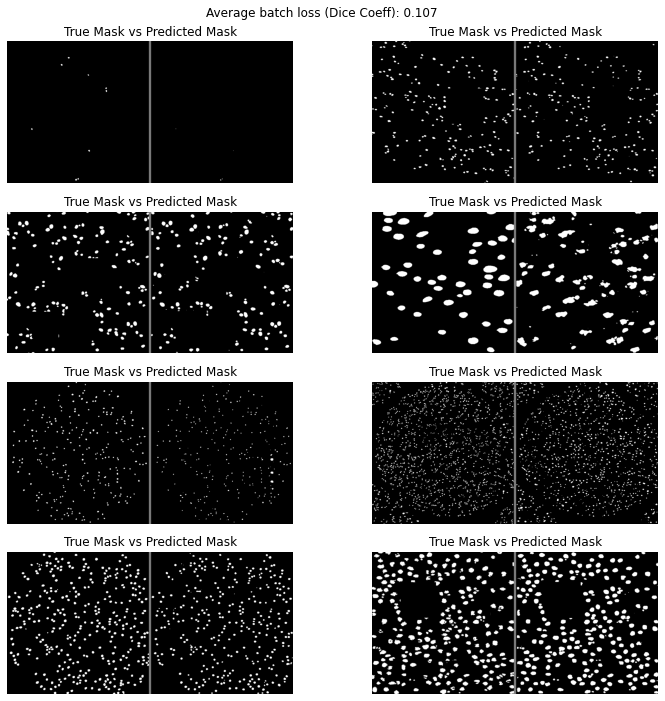

In [ ]:
#Print some example predictions
margin = np.ones((512,8))*0.5

fig, axs = plt.subplots(4,2,figsize=(12,12))
fig.suptitle(f'Average batch loss (Combined Cross Entropy and Dice Loss): {CombinedLoss()(preds, target_masks):.3f}',y=0.92)
axs = axs.flatten()
for i, ax in enumerate(axs):
    target = target_masks.argmax(dim=1)[i]
    output = pred_masks[i]
    comparison = np.concatenate([target,margin,output], axis=1)
    ax.imshow(comparison, cmap='gray')
    ax.set_title('True Mask vs Predicted Mask')
    ax.axis('off')
